In [1]:
import torch
import stable_baselines3
import sys
import numpy as np
import quaternion as quat

print("python version:", sys.version)
print("stable_baselines3 version:", stable_baselines3.__version__)
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda version:", torch.version.cuda)
print("cudnn version:", torch.backends.cudnn.version())

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# set torch default device
torch.set_default_device(device)


# Equation of Motion 3D Quadcopter (no disturbance, stationary target)
## Equations of Motion Variable Skew Quad Plane (VSQP)

# reload sympy
from sympy import *

# Equations of motion 3D quadcopter from https://arxiv.org/pdf/2304.13460.pdf

# w1,w2,w3,w4 are the motor speeds normalized to [-1,1]
# u1,u2,u3,u4 are the motor commands normalized to [-1,1]

state = symbols('x y z v_x v_y v_z phi theta psi p q r w1 w2 w3 w4')
x,y,z,vx,vy,vz,phi,theta,psi,p,q,r,w1,w2,w3,w4 = state
control = symbols('u_1 u_2 u_3 u_4')
u1,u2,u3,u4 = control
## Assume no disturbances
# disturbances = symbols('M_ext_x M_ext_y M_ext_z F_ext_x F_ext_y F_ext_z')
# M_ext_x, M_ext_y, M_ext_z, F_ext_x, F_ext_y, F_ext_z = disturbances

# parameters from https://arxiv.org/pdf/2304.13460.pdf
# change it to the parameters of the VSQP
g = 9.81
Ixx = 0.000906
Iyy = 0.001242
Izz = 0.002054

k_x  = 1.07933887e-05
k_y  = 9.65250793e-06
k_z  = 2.7862899e-05
k_w  = 4.36301076e-08
k_h  = 0.0625501332
k_p  = 1.4119331e-09
k_pv = -0.00797101848
k_q  = 1.21601884e-09
k_qv = 0.0129263739
k_r1 = 2.57035545e-06
k_r2 = 4.10923364e-07
k_rr = 0.000812932607


## this needs to be changed too
tau = 0.06
w_min = 3000
w_max = 11000


# Rotation matrix 
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
R = Rz*Ry*Rx

# Body velocity
vbx, vby, vbz = R.T@Matrix([vx,vy,vz])

# normalized motor speeds to rpm
W1 = (w1+1)/2*(w_max-w_min) + w_min
W2 = (w2+1)/2*(w_max-w_min) + w_min
W3 = (w3+1)/2*(w_max-w_min) + w_min
W4 = (w4+1)/2*(w_max-w_min) + w_min

# first order delay
d_w1 = (u1 - w1)/tau
d_w2 = (u2 - w2)/tau
d_w3 = (u3 - w3)/tau
d_w4 = (u4 - w4)/tau

# derivative of rpm: d/dt[((w+1)/2*(w_max-w_min) + w_min)]
d_W1 = d_w1/2*(w_max-w_min)
d_W2 = d_w2/2*(w_max-w_min)
d_W3 = d_w3/2*(w_max-w_min)
d_W4 = d_w4/2*(w_max-w_min)

# Thrust and Drag
T = -k_w*(W1**2 + W2**2 + W3**2 + W4**2) - k_h*(vbx**2+vby**2) - k_z*vbz*(W1+W2+W3+W4)
Dx = -k_x*vbx*(W1+W2+W3+W4) 
Dy = -k_y*vby*(W1+W2+W3+W4) 

# Moments
Mx = k_p*(W1**2-W2**2-W3**2+W4**2) + k_pv*vby 
My = k_q*(W1**2+W2**2-W3**2-W4**2) + k_qv*vbx 
Mz = k_r1*(-W1+W2-W3+W4) + k_r2*(-d_W1+d_W2-d_W3+d_W4) - k_rr*r 

# Dynamics
d_x = vx
d_y = vy
d_z = vz

d_vx, d_vy, d_vz = Matrix([0,0,g]) + R@Matrix([Dx, Dy,T])

d_phi   = p + q*sin(phi)*tan(theta) + r*cos(phi)*tan(theta)
d_theta = q*cos(phi) - r*sin(phi)
d_psi   = q*sin(phi)/cos(theta) + r*cos(phi)/cos(theta)

d_p     = (q*r*(Iyy-Izz) + Mx)/Ixx
d_q     = (p*r*(Izz-Ixx) + My)/Iyy
d_r     = (p*q*(Ixx-Iyy) + Mz)/Izz

# State space model
f = [d_x, d_y, d_z, d_vx, d_vy, d_vz, d_phi, d_theta, d_psi, d_p, d_q, d_r, d_w1, d_w2, d_w3, d_w4]

# lambdify (Convert a SymPy expression into a function that allows for fast numeric evaluation.)
f_func = lambdify((Array(state), Array(control)), Array(f), 'numpy')
print('state', state)
# extra functions
get_body_velocity = lambdify((Array(state),), Array([vbx, vby, vbz]), 'numpy')



python version: 3.12.1 | packaged by conda-forge | (main, Dec 23 2023, 07:53:56) [MSC v.1937 64 bit (AMD64)]
stable_baselines3 version: 2.2.1
torch version: 2.2.0
cuda available: True
cuda version: 12.1
cudnn version: 8801
device: cuda
state (x, y, z, v_x, v_y, v_z, phi, theta, psi, p, q, r, w1, w2, w3, w4)


# Define the environment for the landing phase 

In [2]:
from gymnasium import spaces
from stable_baselines3.common.vec_env import VecEnv
from scipy.spatial.transform import Rotation as R

class VSQPlanding(VecEnv):
    def __init__(self,
                 num_envs,
                 start_drone_pos, 
                 start_drone_att,
                 start_platform_pos,
                 start_platform_att,
                 pause_if_collision = True
                 ):

        # define the trajectory
        self.start_drone_pos = start_drone_pos.astype(np.float32)
        self.start_drone_att = start_drone_att.astype(np.float32)
        self.start_platform_pos = start_platform_pos.astype(np.float32)
        self.start_platform_att = start_platform_att.astype(np.float32)
        
        # Pause if drone ends up inside the box
        self.pause_if_collision = pause_if_collision

        # Find the relative position of the drone wrt the platform
        self.drone_pos_rel = self.start_drone_pos - self.start_platform_pos
        # Rotation matrices for the drone and the platform
        att_drone = self.start_drone_att # (3,)
        att_platform = self.start_platform_att # (1,3)
        # reshape the att of the platform since the function requires (3,)
        att_platform_ = np.reshape(att_platform, (3,))
        self.R_platform = self.rotation_matrix(att_platform_)
        self.R_drone = self.rotation_matrix(att_drone)

        # # Relative rotation matrix of the drone wrt the platform (R_drone first transforms vectors from the drone's local frame to the global frame then from the global to ship with R.platform.T)
        # self.R_rel = self.R_platform.T @ self.R_drone
        # # not even used currently
        # self.drone_pos_rel =  self.R_platform.T @ self.drone_pos_rel.T # (3,3) @ (3,3) 

        # define the target platform for each environment (same platform for the first case)
        self.target_platforms = np.zeros(num_envs,dtype=int)

        # rpm commands (cont)
        action_space = spaces.Box(low = -1, high = 1, shape = (4,))
        # observation space (in the platform's reference frame)
        self.drone_state_len = 16; #pos[P], vel[P], att[eulerB->G], rates[B], rpms, 
        # self.ship_state_len = 9; #pos[P], vel[G], att[eulerB->G]
        self.total_state_len = self.drone_state_len 
        observation_space = spaces.Box(
            low  = np.array([-np.inf]*self.total_state_len),
            high = np.array([ np.inf]*self.total_state_len))
      
        # Initialize the parent class
        VecEnv.__init__(self,num_envs, observation_space, action_space)
        
        ## env specific definitions
        # world state: pos[W], vel[W], att[eulerB->W], rates[B], rpms
        self.world_states = np.zeros((num_envs,self.total_state_len), dtype=np.float32)
        # observation state
        self.states = np.zeros((num_envs,self.total_state_len), dtype=np.float32)
        #self.max_steps = 1200      # Maximum number of steps in an episode
        self.max_steps = 500
        self.dt = np.float32(0.01) # Time step duration

        self.step_counts = np.zeros(num_envs, dtype=int)
        self.actions = np.zeros((num_envs,4), dtype=np.float32)
        self.dones = np.zeros(num_envs, dtype=bool)
        self.inside_landing_box = np.zeros(num_envs,dtype=bool)

        self.update_states = self.update_states_platform

        self.pause = False

    def rotation_matrix(self,att):
        phi, the, psi = att
        Rz = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi), 0],
            [0, 0, 1]])

        Ry = np.array([
            [np.cos(the), 0, np.sin(the)],
            [0, 1, 0],
            [-np.sin(the), 0, np.cos(the)]])

        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi)]])

        # Combine rotations
        R = Rz @ Ry @ Rx
        return R

    def update_states_platform(self):

        # Transform pos and vel in platform frame (do not change)
        plat_pos = self.start_platform_pos
        # plat_vel = np.array([0, 0, 0]) # stationary for now
        plat_att = self.start_platform_att

        # new state array 
        new_states = np.zeros_like(self.states) # (10,16)

        # Update relative positions
        rel_pos_in_plat_frame = (self.world_states[:,0:3] - self.start_platform_pos) @ self.R_platform.T
        new_states[:,0:3] = rel_pos_in_plat_frame
        #print('updated_pos', rel_pos_in_plat_frame)

        # update relative velocities
        rel_vel_in_plat_frame = self.world_states[:,3:6] @ self.R_platform.T
        new_states[:,3:6] = rel_vel_in_plat_frame
        #print('updated_vel', rel_vel_in_plat_frame)

        # update relative attitude
        # new_states[:,6:9] = self.world_states[:,6:9]
        # att_drone = self.world_states[:,6:9]
        # for i in range(self.num_envs):
        #     rot_mat = self.rotation_matrix(att_drone[i,6:9].T)
        #     rel
        # rot_drone = self.rotation_matrix(att_drone)
        # rel_rot = self.R_platform.T @ rot_drone
        # # initialize using a rotation matrix
        # r = R.from_matrix(rel_rot)
        # rel_att = r.as_euler('xyz')
        new_states[:,6:9] = self.world_states[:,6:9]
        # print('rel_att', rel_att)

        # Update rates
        new_states[:,9:12] = self.world_states[:,9:12]
        #print('body rates',new_states[:,9:12])

        # Update rpms
        new_states[:,12:16] = self.world_states[:,12:16]
        self.states = new_states
                
    def reset_(self,dones):
        num_reset = dones.sum()

        x0 = np.random.uniform(-1,1, size=(num_reset,)) + self.start_drone_pos[0]
        y0 = np.random.uniform(-1,1, size=(num_reset,)) + self.start_drone_pos[1]
        z0 = np.random.uniform(-1,1, size=(num_reset,)) + self.start_drone_pos[2]
        
        vx0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vy0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vz0 = np.random.uniform(-0.5,0.5, size=(num_reset,))

        # vx0 = np.random.uniform(-5,5, size=(num_reset,))
        # vy0 = np.random.uniform(-5,5, size=(num_reset,))
        # vz0 = np.random.uniform(-5,5, size=(num_reset,))
        
        phi0   = np.random.uniform(-np.pi/9,np.pi/9, size=(num_reset,))
        theta0 = np.random.uniform(-np.pi/9,np.pi/9, size=(num_reset,))
        psi0   = np.random.uniform(-np.pi,np.pi, size=(num_reset,))
        
        p0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        q0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        r0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        
        w10 = np.random.uniform(-1,1, size=(num_reset,))
        w20 = np.random.uniform(-1,1, size=(num_reset,))
        w30 = np.random.uniform(-1,1, size=(num_reset,))
        w40 = np.random.uniform(-1,1, size=(num_reset,))

        self.world_states[dones] = np.stack([x0, y0, z0, vx0, vy0, vz0, phi0, theta0, psi0, p0, q0, r0, w10, w20, w30, w40], axis=1)

        self.step_counts[dones] = np.zeros(num_reset)

            # update states
        self.update_states()
        return self.states

    def reset(self):
        return self.reset_(np.ones(self.num_envs, dtype=bool))

    def step_async(self, actions):
        self.actions = actions

    def step_wait(self):

        new_states = self.world_states + self.dt*f_func(self.world_states.T, self.actions.T).T

        self.step_counts += 1

        # The simpliest reward function
        pos_new_drone = new_states[:,0:3]
        vel_new_drone = new_states[:,3:6] 
        vel_plat_new = 0 # assuming a stationary target
        pos_platform = self.start_platform_pos

        # REWARD 
        # simple penalize the drone with distance to the target position
        # rel_dist = np.linalg.norm(pos_new_drone - pos_platform, axis = 1)
        # # velocity
        # rel_vel = np.linalg.norm(vel_new_drone - vel_plat_new, axis = 1)
        
        # rewards = rel_dist*-100 + rel_vel*-10

        pos_old = self.world_states[:,0:3]
        pos_new = new_states[:,0:3]
        vel_old = self.world_states[:,3:6]
        vel_new = new_states[:,3:6] 
        # vel_plat_new = 0 # assuming a stationary target
        # # 1 cause there is only one platform to track 
        # pos_platform = self.start_platform_pos[self.target_platforms % 1]
        # # pos_att = self.start_platform_att

        # ## If the platform's position and attitude chnages over time
        # # plat_pos = self.update_platform_position()
        # # plat_att = self.update_platform_attitude()
        # # R_platform = self.rotation_matrix(plat_att)
        # # For alignment, ensure the drone's descent vector aligns with the platform's normal
        # # Assuming you have the drone's descent vector as `descent_vector`
        # # alignment_with_platform = np.dot(descent_vector, normal_vector) / (np.linalg.norm(descent_vector) * np.linalg.norm(normal_vector))
        # # is_properly_aligned = alignment_with_platform > 0.95  # Example alignment threshold


        drone_pos_rel_new = pos_new - pos_platform # (10,3) , (1,3)
        # # rehape for the transformation
        drone_pos_rel_local_ = self.R_platform.T @ drone_pos_rel_new.T # (3,3)x(3,10) Transform to platform's frame
        drone_pos_rel_local = drone_pos_rel_local_.T
        # # Reward function
        
        # 1. Distance to platform (calculates the Euclidean distance from the drones position to the target gate before and after an action)
        # the reward increases the amount that the drone gets closer to the target
        d2g_old = np.linalg.norm(pos_old - pos_platform, axis = 1)
        d2g_new = np.linalg.norm(pos_new - pos_platform, axis = 1)
        v2g_old = np.linalg.norm(vel_old, axis = 1)
        v2g_new = np.linalg.norm(vel_new, axis = 1)
        #rewards = (d2g_old - d2g_new)*10 + (v2g_old - v2g_new)*1

        rewards = (d2g_old - d2g_new)*1 - 0.001*v2g_new**2
        


        # 2. Do not consider velocity differences if you assume a stationary target
        # 2. Penalize rapid rotations or aggressive maneuvers
        rat_penalty = -0.01*np.linalg.norm(new_states[:,9:12], axis=1)
        ## may require another definition outside the landing box
        rewards += rat_penalty

        # 3. Platform passed/collision occured
        normal_local = np.array([0, 0, 1])  # Normal in platform's local frame
        normal_global = self.R_platform @ normal_local  # Transform to global frame ??
        # Calculate perpendicular distance from the drone to the platform along the platform's normal
        distance_to_platform = np.dot(drone_pos_rel_new, normal_global)
        platform_size = np.array([1,1])
        # check if the drone is within the platform's bounds and close to the surface
        collision_threshold = 0.1 # this can be determined according to the drone body
        # is_within_bounds = abs(drone_pos_rel_local[:,0]) <= platform_size[0] and \
        #                     abs(drone_pos_rel_local[:,1]) <= platform_size[1]
        is_within_bounds = np.logical_and(abs(drone_pos_rel_local[:,0]) <= platform_size[0],abs(drone_pos_rel_local[:,1]) <= platform_size[1])
        # this is only for representing the collision with the landing platform 
        is_collision_altitude = abs(distance_to_platform) <= collision_threshold
        is_colliding = np.logical_and(is_within_bounds, is_collision_altitude)
       
        rewards[is_colliding] = 10

        # 1. soft landing
        soft_landing = (v2g_new < 0.5) & is_colliding
        rewards[soft_landing] = 10

        # 2. hard landing
        hard_landing = (v2g_new > 0.5) & is_colliding
        rewards[hard_landing] = -10


        # # 4. Reward for landing
        # # define the acceptable bounds
        # x_bounds = (-1, 1)  # Acceptable x-range in platform's frame
        # y_bounds = (-1, 1)  # Acceptable y-range in platform's frame
        # z_bounds = (-1, 0)  # Acceptable height above platform for landing # how to define the bounds in a local reference frame

        # # check if drone is within the landing zone
        # within_x = np.logical_and(x_bounds[0] <= drone_pos_rel_local[:,0], drone_pos_rel_local[:,0] <= x_bounds[1])
        # within_y = np.logical_and(y_bounds[0] <= drone_pos_rel_local[:,0], drone_pos_rel_local[:,0] <= y_bounds[1])
        # within_z = np.logical_and(z_bounds[0] <= drone_pos_rel_local[:,0], drone_pos_rel_local[:,0] <= z_bounds[1])

        # is_within_bounds_land = np.logical_and(within_x,within_y,within_z)
        
        # rewards[is_within_bounds_land] = 10

        # # Check out of bounds
        out_of_bounds = np.any(np.abs(new_states[:,0:3]) > 100, axis=1) | np.any(np.abs(new_states[:,9:12]) > 1000, axis=1)
        rewards[out_of_bounds] = -10

        # body_R = abs(new_states[:,9:12])>1000
        # bool_R = np.any(body_R, axis=1)

        # check number of steps
        max_steps_reached = self.step_counts >= self.max_steps

        ground_is_collision = pos_new_drone[:,2] > 0 

        rewards[ground_is_collision] = -10

        # should I update the target?
        # check if the episode is done
        # dones = out_of_bounds | max_steps_reached | is_within_bounds | is_colliding  #| self.final_gate_passed 
        dones = max_steps_reached | out_of_bounds  | ground_is_collision | is_colliding #| self.final_gate_passed 

        self.dones = dones

        # Pause if collision
        if self.pause:
            dones = dones & ~dones
            self.dones = dones
        # elif self.pause_if_collision:
        #     #
        #     update = ~dones #~(gate_collision | ground_collision)
        #     # Update world states
        #     self.world_states[update] = new_states[update]
        #     self.update_states()
        #     # Reset env if done (and update states)
        #     # self.reset_(dones)
        else:
            # Update world states
            self.world_states = new_states
            # reset env if done (and update states)
            self.reset_(dones)
        # Write info dicts
        infos = [{}] * self.num_envs
        for i in range(self.num_envs):
            if dones[i]:
                infos[i]["terminal_observation"] = self.states[i]
            if max_steps_reached[i]:
                infos[i]["TimeLimit.truncated"] = True
        return self.states, rewards, dones, infos

    def close(self):
        pass

    def seed(self, seed=None):
        pass

    def get_attr(self, attr_name, indices=None):
        raise AttributeError()

    def set_attr(self, attr_name, value, indices=None):
        pass

    def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
        pass

    def env_is_wrapped(self, wrapper_class, indices=None):
        return [False]*self.num_envs

    def render(self, mode='human'):
        # Outputs a dict containing all information for rendering
        state_dict = dict(zip(['x','y','z','vx','vy','vz','phi','theta','psi','p','q','r','w1','w2','w3','w4'], self.world_states.T))
        # Rescale actions to [0,1] for rendering
        action_dict = dict(zip(['u1','u2','u3','u4'], (np.array(self.actions.T)+1)/2))
        return {**state_dict, **action_dict}
    

# Define Simulation Environment

In [4]:
import importlib
from quadcopter_animation import animation_cansu
importlib.reload(animation_cansu)

plat_pos = np.array([[0,0,-1]]) # shape converted to (1,3) from (3,)

# plat_att = np.array([[np.pi/9, np.pi/9, np.pi/9]]) # shape: (1,3) , to call a[][], not necessary if for i in structure is used

plat_att = np.array([[0, 0, 0]]) # shape: (1,3) , to call a[][], not necessary if for i in structure is used

start_pos = np.array([5,-5,-5])

start_att = np.array([0,0,0])

num = 10
env = VSQPlanding(num_envs=num, start_drone_pos=start_pos, start_drone_att=start_att,start_platform_pos=plat_pos,start_platform_att=plat_att,pause_if_collision= False )

# Run a random agent
env.reset()
done = False
def run():
    global done
    # for i in range(100):
    action = np.random.uniform(-1,1, size=(num,4))
    state, reward, done, _ = env.step(action)
    #print('action', action, 'state', state, 'reward', reward, 'done', done)
    # print('reward', reward)
    # print(state[0][-4:])
    # print(env.disturbances[0])
    if reward[0] > 70:
        print("reward:", reward)
    return env.render()

animation_cansu.view(run,gate_pos=plat_pos, gate_att=plat_att) #, record_steps=1000, show_window=True)
#run()


# Train PPO Model

In [ ]:
import os
from stable_baselines3 import PPO
from datetime import datetime
from stable_baselines3.common.vec_env import VecMonitor
import importlib
from quadcopter_animation import animation

models_dir = 'models/E2E'
log_dir = 'logs/E2E'
video_log_dir = 'videos/E2E'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(video_log_dir):
    os.makedirs(video_log_dir)

# Date and time string for unique folder names
datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the environment
env = VSQPlanding(num_envs=100, start_drone_pos=start_pos, start_drone_att=start_att,start_platform_pos=plat_pos,start_platform_att=plat_att,pause_if_collision= True )
test_env = VSQPlanding(num_envs=10, start_drone_pos=start_pos, start_drone_att=start_att,start_platform_pos=plat_pos,start_platform_att=plat_att,pause_if_collision= True )


# env = Quadcopter3DGates(num_envs=100, gates_pos=plat_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1)
# test_env = Quadcopter3DGates(num_envs=10, gates_pos=plat_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True)

# Wrap the environment in a Monitor wrapper
env = VecMonitor(env)

# disturbance ranges
# disturbance_ranges = np.array([
#     [-0.03, 0.03],
#     [-0.03, 0.03],
#     [-0.01, 0.01],
#     [0, 0],
#     [0, 0],
#     [-0.5, 0.5],
# ])
# env.venv.disturbance_ranges = disturbance_ranges
# test_env.disturbance_ranges = disturbance_ranges

# MODEL DEFINITION
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[120,120,120], vf=[120,120,120])], log_std_init = 0)
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=0,
    tensorboard_log=log_dir,
    n_steps=500,
    batch_size=2000,
    n_epochs=5,
    gamma=0.999
    #learning_rate=0.00001
)

print(model.policy)
print(model.num_timesteps)

def animate_policy(model, env, deterministic=False, log_times=False, **kwargs):
    env.reset()
    def run():
        actions, _ = model.predict(env.states, deterministic=deterministic)

        states, rewards, dones, infos = env.step(actions)
        if log_times:
            if rewards[0] == 10:
                print(env.step_counts[0]*env.dt)
        return env.render()
    animation_cansu.view(run, gate_pos=env.start_platform_pos, gate_att=env.start_platform_att, **kwargs)

# animate untrained policy (use this to set the recording camera position)
animate_policy(model, test_env)

# training loop saves model every 10 policy rollouts and saves a video animation
def train(model, test_env, log_name, n=10000000000):
    # save every 10 policy rollouts
    TIMESTEPS = model.n_steps*env.num_envs*10
    for i in range(0,n):
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=log_name)
        time_steps = model.num_timesteps
        # save model
        model.save(models_dir + '/' + log_name + '/' + str(time_steps))
        # save policy animation
        animate_policy(
            model,
            test_env,
            record_steps=1200,
            record_file=video_log_dir + '/' + log_name + '/' + str(time_steps) + '.mp4',
            show_window=False
        )

In [ ]:
# run training loop
train(model, test_env,'landing_v17')
#tensorboard --logdir="logs/E2E/landing__0/"

# Simulate PPO model

In [405]:
start_pos = np.array([10,-5,-15])

test_env = VSQPlanding(num_envs=1, 
                       start_drone_pos=start_pos, 
                       start_drone_att=start_att,
                       start_platform_pos=plat_pos,
                       start_platform_att=plat_att,
                       pause_if_collision= True)

# path of the model
path = 'models/E2E/landing_v17/2500000'
model = PPO.load(path)
animate_policy(model, test_env, deterministic=False, log_times=True)


c:\Users\cnsyk\anaconda3\envs\quadRL\Lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


# EVALUATION

Logging

In [406]:
def run(num_env, height = -start_pos[2], deviation = start_pos[0]):
    test_env.max_steps = 10000
    test_env.reset()
    n_e = num_env

    # empty lists 
    time = []
    state_traj = []
    action_traj = []
    done = False
    while not done:
        actions, _ = model.predict(test_env.states, deterministic= False)
        states, rewards, done, infos = test_env.step(actions)
        if done:
            break
        state_traj.append(test_env.world_states[0].copy())
        action_traj.append(actions[0].copy())
        time.append(test_env.step_counts[0]*test_env.dt)
        # time.append(test_env.step_counts[0]*test_env.dt)
    print('Simulation for the env', num_env,'completed!', 'time', len(time), 'info', infos)
    make_logdict(state_traj, action_traj,time, num_env, height, deviation)


def make_logdict(state_traj, action_traj, num_env, time, height, deviation):

    # make log dict
    log_dict = {}
    state_traj = np.array(state_traj)
    action_traj = np.array(action_traj)
  

    log_dict['t'] = time
    log_dict['x'] = state_traj[:,0]
    log_dict['y'] = state_traj[:,1]
    log_dict['z'] = state_traj[:,2]
    log_dict['vx'] = state_traj[:,3]
    log_dict['vy'] = state_traj[:,4]
    log_dict['vz'] = state_traj[:,5]
    log_dict['V'] = np.sqrt(state_traj[:,3]**2 + state_traj[:,4]**2 + state_traj[:,5]**2)
    log_dict['phi'] = state_traj[:,6]
    log_dict['theta'] = state_traj[:,7]
    log_dict['psi'] = state_traj[:,8]
    log_dict['u1'] = (action_traj[:,0]+1)/2
    log_dict['u2'] = (action_traj[:,1]+1)/2
    log_dict['u3'] = (action_traj[:,2]+1)/2
    log_dict['u4'] = (action_traj[:,3]+1)/2
    log_dict['u'] = np.stack([log_dict['u1'], log_dict['u2'], log_dict['u3'], log_dict['u4']], axis=1)


    # save log dict 
    # save log dict to flight_data/simulation_logs
    # make folder
    name = '5' + '_' + str(height) + '_' + str(deviation) +'_' + str(0) 
    # folder = 'flight_data/evaluation_parrot/v17'
    # if not os.path.exists(folder):
    #     os.makedirs(folder)
    # # save dict as npz
    # np.savez(folder + '/' + name, **log_dict)
    # print('dict saved!')


    # name = 'V17'
    folder = 'flight_data/evaluation_parrot/V17'
    if not os.path.exists(folder):
        os.makedirs(folder)
    # save dict as npz
    np.savez(folder + '/' + name, **log_dict)

Run for evaluation

In [407]:
global num_env
num_envs = 1
for i in range(num_envs):
    test_env.reset()
    run(num_env=i)
    

Simulation for the env 0 completed! time 9999 info [{'terminal_observation': array([ 9.1420975e+00, -5.2936091e+00, -1.4776961e+01,  3.0672576e-02,
       -4.4794953e-01, -4.9975169e-01,  2.5667056e-01, -2.8140813e-01,
       -2.2141719e+00, -7.6152831e-02,  3.6090808e-03,  9.3973517e-02,
       -3.4304166e-01,  2.4387634e-01, -4.5474093e-02, -5.1096971e-03],
      dtype=float32), 'TimeLimit.truncated': True}]


Load Files

In [437]:
def load_log(base_path, file_name):
    full_path = f'{base_path}{file_name}'
    data = np.load(full_path, allow_pickle=True)
    if 'z' in data:
        return {'zd': data['z']}
    else:
        print(f"Data keys missing in file: {full_path}")
        return None


def load_log_data(base_path, file_name):
    full_path = f'{base_path}{file_name}'
    data = np.load(full_path, allow_pickle=True)
    return data
  

# Base path and specific files
base_path_4 = 'flight_data/evaluation_parrot/v17/'
base_path_3 = 'flight_data/evaluation_parrot/v16/'
base_path_2 = 'flight_data/evaluation_parrot/V15/'
base_path_1 = 'flight_data/evaluation_parrot/V12/'


# with no deviation - 0
file_name_b3_heights_0 = [
    '5_5_5_0.npz',  # Example for deviation 5
    '5_10_5_0.npz', 
    '5_15_5_0.npz'  
]

# with no deviation - 0
file_name_b3_dev7_0 = [
    '5_5_7_0.npz',  # Example for deviation 5
    '5_10_7_0.npz',
    '5_15_7_0.npz'
]

# with no deviation - 0
file_name_b3_dev10_0 = [
    '5_5_10_0.npz',  # Example for deviation 5
    '5_10_10_0.npz',
    '5_15_10_0.npz'
]
## BASE 1 - V12
# with no deviation - 0
# with no deviation - 0
file_name_b1_heights_0 = [
    '5_5_5_0.npz',  # Example for deviation 5
    '5_10_5_0.npz', 
    '5_15_5_0.npz'  
]

# with no deviation - 0
file_name_b1_dev7_0 = [
    '5_5_7_0.npz',  # Example for deviation 5
    '5_10_7_0.npz',
    '5_15_7_0.npz'
]

# with no deviation - 0
file_name_b1_dev10_0 = [
    '5_5_10_0.npz',  # Example for deviation 5
    '5_10_10_0.npz',
    '5_15_10_0.npz'
]

## BASE 1 - V15
# with no deviation - 0
# with no deviation - 0
file_name_b2_heights_0 = [
    '5_5_5_0.npz',  # Example for deviation 5
    '5_10_5_0.npz', 
    '5_15_5_0.npz'  
]

# with no deviation - 0
file_name_b2_dev7_0 = [
    '5_5_7_0.npz',  # Example for deviation 5
    '5_10_7_0.npz',
    '5_15_7_0.npz'
]

# with no deviation - 0
file_name_b2_dev10_0 = [
    '5_5_10_0.npz',  # Example for deviation 5
    '5_10_10_0.npz',
    '5_15_10_0.npz'
]

## BASE 1 - V17
# with no deviation - 0
# with no deviation - 0
file_name_b4_heights_0 = [
    '5_5_5_0.npz',  # Example for deviation 5
    '5_10_5_0.npz', 
    '5_15_5_0.npz'  
]

# with no deviation - 0
file_name_b4_dev7_0 = [
    '5_5_7_0.npz',  # Example for deviation 5
    '5_10_7_0.npz',
    '5_15_7_0.npz'
]

# with no deviation - 0
file_name_b4_dev10_0 = [
    '5_5_10_0.npz',  # Example for deviation 5
    '5_10_10_0.npz',
    '5_15_10_0.npz'
]


# 0 files
# log_1_0 = [load_log_data(base_path_1, file) for file in files_1]

# V16
log_b3_h0 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_0]
log_b3_h1 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_1]

log_b3_d7_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_0]
log_b3_d7_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_1]

log_b3_d10_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_0]
log_b3_d10_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_1]


# V12
log_b1_h0 = [load_log_data(base_path_1, file) for file in file_name_b1_heights_0]
log_b1_d7_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev7_0]
log_b1_d10_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev10_0]

# V15
log_b2_h0 = [load_log_data(base_path_2, file) for file in file_name_b2_heights_0]
log_b2_d7_0 = [load_log_data(base_path_2, file) for file in file_name_b2_dev7_0]
log_b2_d10_0 = [load_log_data(base_path_2, file) for file in file_name_b2_dev10_0]

# V17
log_b4_h0 = [load_log_data(base_path_4, file) for file in file_name_b4_heights_0]
log_b4_d7_0 = [load_log_data(base_path_4, file) for file in file_name_b4_dev7_0]
log_b4_d10_0 = [load_log_data(base_path_4, file) for file in file_name_b4_dev10_0]



Plot (FAULT SCENARIOS INCLUDED)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

def plot_trajectories(logs1):    
    fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)
    colors = ['salmon', 'turquoise', '#fdaa48']  # Define more colors as needed
    styles = ['-', '--']
    titles = ['f = 0Hz', 'f = 0.5Hz', 'f = 0.1Hz']
    labels = ['deviation [0m]', 'deviation [2m]', 'deviation [4m]']
    lw = 3
    k = 0
    for i, logs_0 in enumerate(logs1):
        for log in logs_0:
            if log is not None:
                if i == 0:
                    if  k==2:
                        # First row: x, y, z
                        time = np.linspace(0, len(log['x'])/100, len(log['x']))
                        ax[0, 0].plot(time, log['x'], linestyle=styles[i % 2], linewidth = lw, color = 'red')
                        ax[0, 1].plot(time, -log['y'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')
                        ax[0, 2].plot(time, -log['z'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')

                        # Second row: vx, vy, vz
                        ax[1, 0].plot(time, log['vx'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')
                        ax[1, 1].plot(time, log['vy'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')
                        ax[1, 2].plot(time, log['vz'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')

                        # Third row: V, phi, theta, psi
                        ax[2, 0].plot(time, log['phi'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')
                        ax[2, 1].plot(time, log['theta'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')
                        ax[2, 2].plot(time, log['psi'], linestyle=styles[i % 2],  linewidth = lw, color = 'red')
                    else:
                        time = np.linspace(0, len(log['x'])/100, len(log['x']))
                        ax[0, 0].plot(time, log['x'], linestyle=styles[i % 2], linewidth = lw)
                        ax[0, 1].plot(time, -log['y'], linestyle=styles[i % 2],  linewidth = lw)
                        ax[0, 2].plot(time, -log['z'], linestyle=styles[i % 2],  linewidth = lw)

                        # Second row: vx, vy, vz
                        ax[1, 0].plot(time, log['vx'], linestyle=styles[i % 2],  linewidth = lw)
                        ax[1, 1].plot(time, log['vy'], linestyle=styles[i % 2],  linewidth = lw)
                        ax[1, 2].plot(time, log['vz'], linestyle=styles[i % 2],  linewidth = lw)

                        # Third row: V, phi, theta, psi
                        ax[2, 0].plot(time, log['phi'], linestyle=styles[i % 2],  linewidth = lw)
                        ax[2, 1].plot(time, log['theta'], linestyle=styles[i % 2],  linewidth = lw)
                        ax[2, 2].plot(time, log['psi'], linestyle=styles[i % 2],  linewidth = lw)
                    k += 1
            
                    

    y_labels = ['$p_n$ (m)','$p_e$ (m)','$p_d$ (m)','$v_n$ (m/s)','$v_e$ (m/s)','$v_d$ (m/s)', '$\phi$ (rad)','$\Theta$ (rad)','$\psi$ (rad)']
 
    for i in range(3):
        for j in range(3):
            ax[i, j].grid(True, alpha=0.0)
            ax[i, j].set_facecolor('snow')
            ax[i, j].tick_params(axis='both', which='major', labelsize=16)
            ax[i, j].set_ylabel(y_labels[i*3+j], fontsize=16)
            ax[i, j].set_xlabel('Time (s)', fontsize=16)

    fig.legend(('h:5 m','h:10 m','h:15 m'), loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=5, fontsize = 16)
    fig.suptitle('deviation = 4m', fontsize=18, fontweight = 'bold')
    # ax[0, 2].set_ylim(0,16)
         

    fig.savefig("parrot_v16_d4.pdf", bbox_inches='tight')
    plt.show()


# log_b3_h0 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_0]
# log_b3_h1 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_1]

# log_b3_d7_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_0]
# log_b3_d7_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_1]

# log_b3_d10_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_0]
# log_b3_d10_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_1]

##
# log_b1_h0 = [load_log_data(base_path_1, file) for file in file_name_b1_heights_0]
# log_b1_d7_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev7_0]
# log_b1_d10_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev10_0]

# Plotting
log_list = [log_b3_d10_1,log_b3_d10_1]


plot_trajectories(log_list) 

<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\T'
<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\T'
<>:35: SyntaxWarning: invalid escape sequence '\p'
C:\Users\cnsyk\AppData\Local\Temp\ipykernel_308\2598090672.py:35: SyntaxWarning: invalid escape sequence '\p'
  y_labels = ['$p_n$ (m)','$p_e$ (m)','$p_d$ (m)','$v_n$ (m/s)','$v_e$ (m/s)','$v_d$ (m/s)', '$\phi$ (rad)','$\Theta$ (rad)','$\psi$ (rad)']
C:\Users\cnsyk\AppData\Local\Temp\ipykernel_308\2598090672.py:35: SyntaxWarning: invalid escape sequence '\T'
  y_labels = ['$p_n$ (m)','$p_e$ (m)','$p_d$ (m)','$v_n$ (m/s)','$v_e$ (m/s)','$v_d$ (m/s)', '$\phi$ (rad)','$\Theta$ (rad)','$\psi$ (rad)']
C:\Users\cnsyk\AppData\Local\Temp\ipykernel_308\2598090672.py:35: SyntaxWarning: invalid escape sequence '\p'
  y_labels = ['$p_n$ (m)','$p_e$ (m)','$p_d$ (m)','$v_n$ (m/s)','$v_e$ (m/s)','$v_

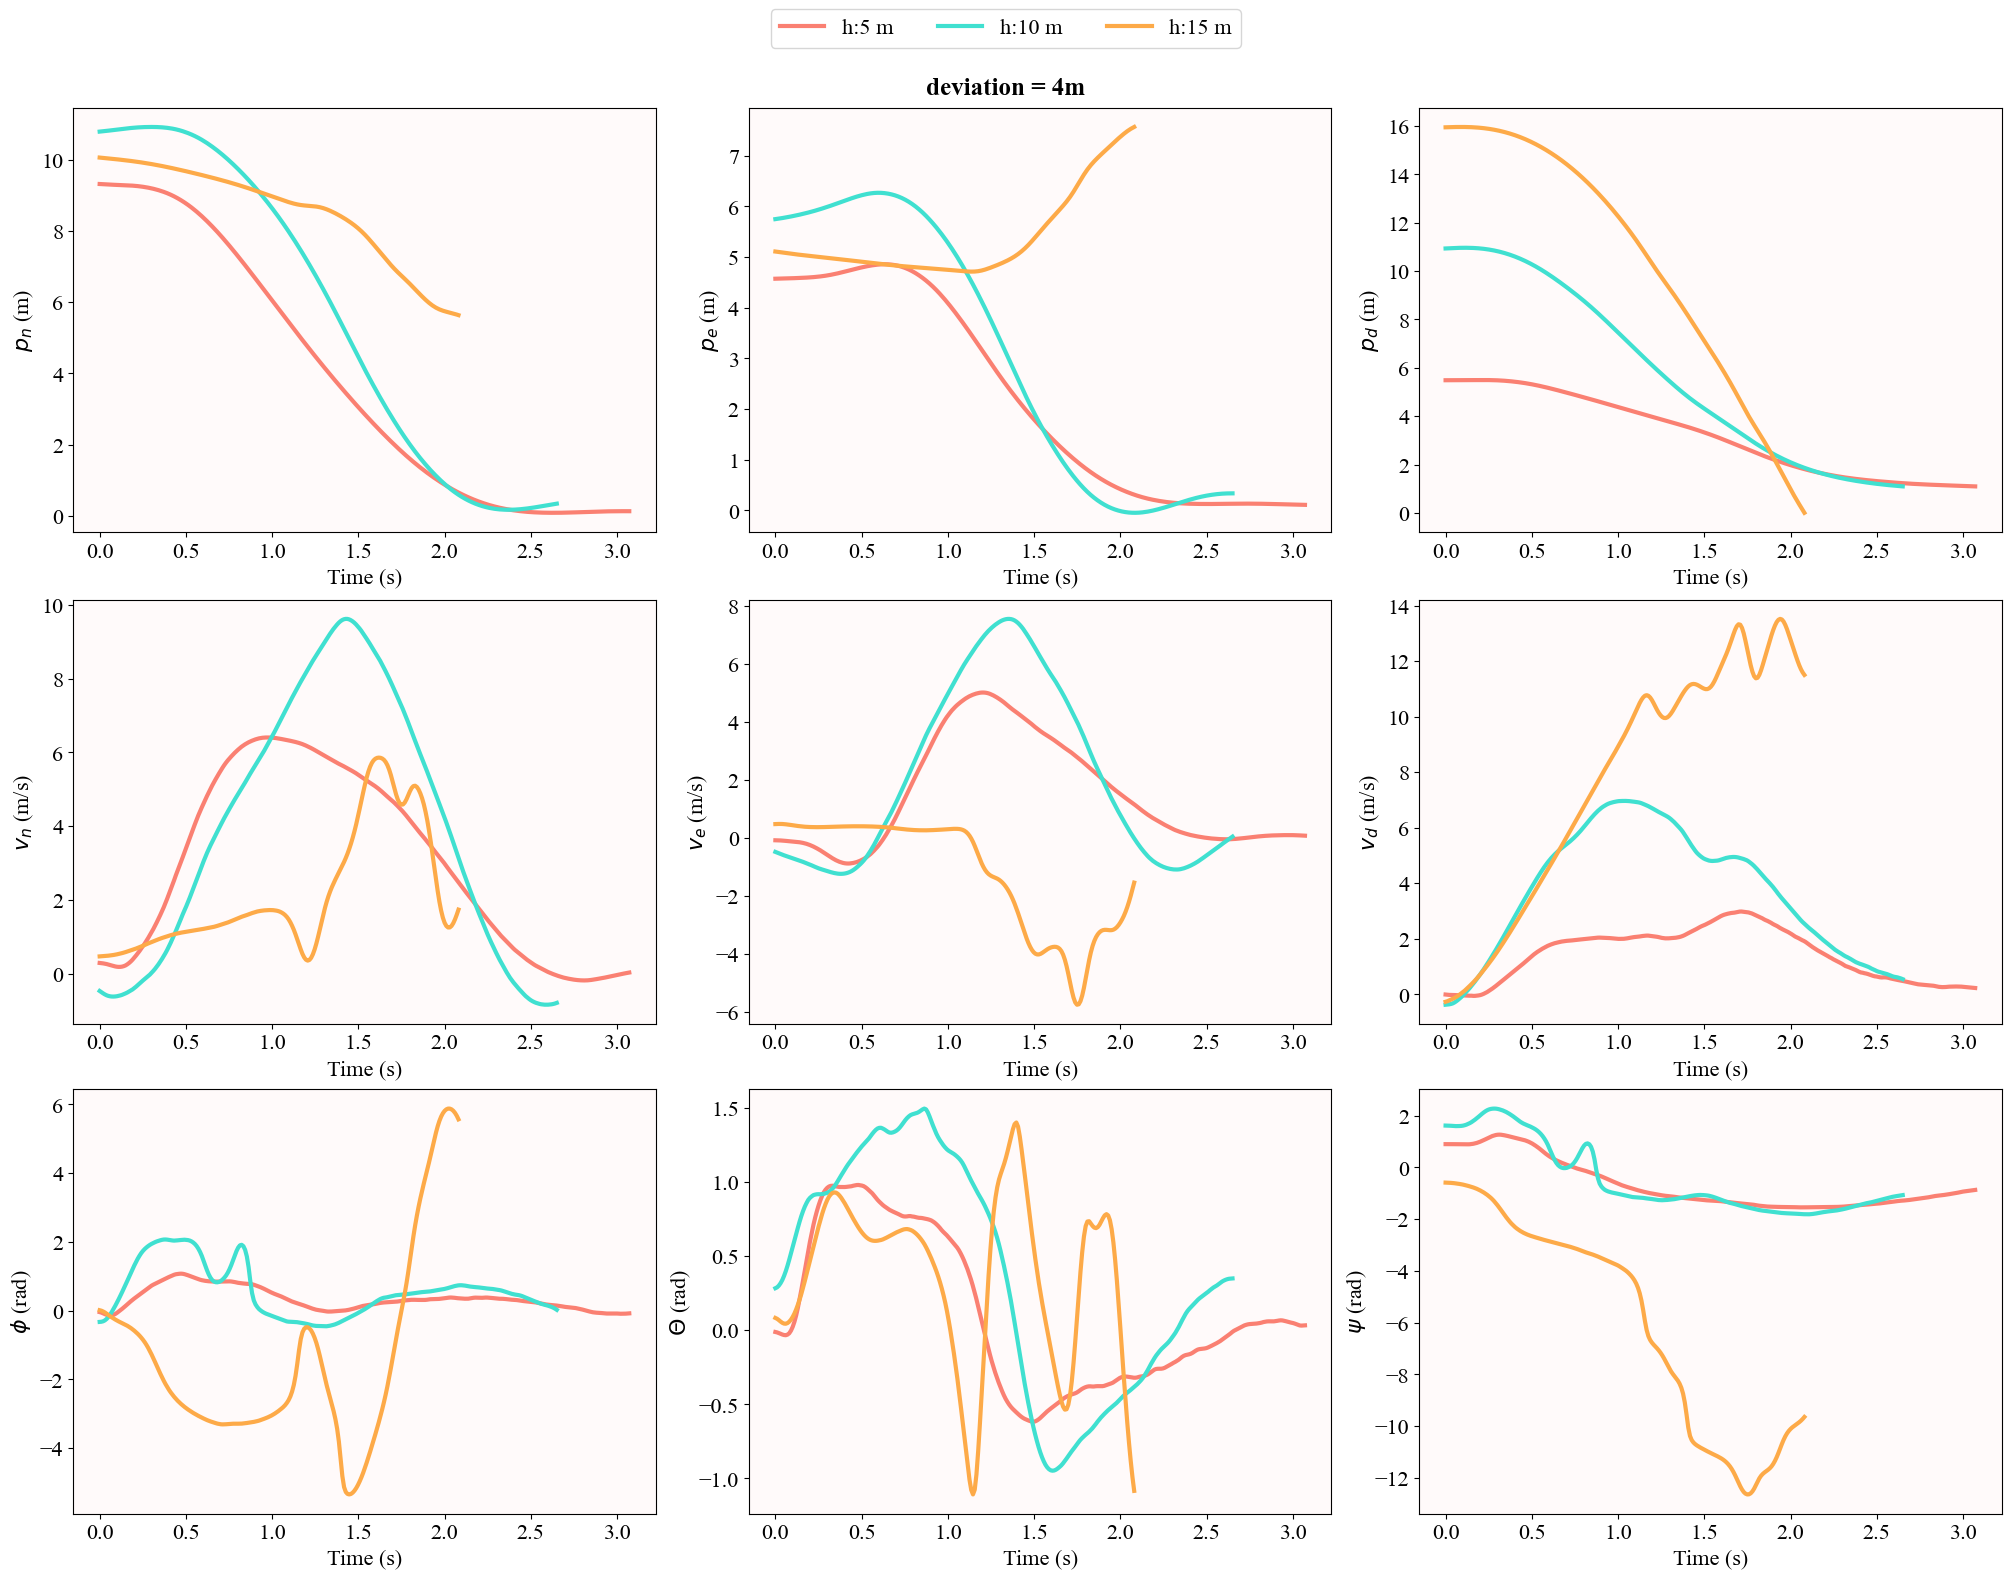

In [428]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

def plot_trajectories(logs1):    
    fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)
    colors = ['salmon', 'turquoise', '#fdaa48']  # Define more colors as needed
    styles = ['-', '--']
    titles = ['f = 0Hz', 'f = 0.5Hz', 'f = 0.1Hz']
    labels = ['deviation [0m]', 'deviation [2m]', 'deviation [4m]']
    lw = 3
    k = 0
    for i, logs_0 in enumerate(logs1):
        for log in logs_0:
            if log is not None:
                if i == 0:
                    time = np.linspace(0, len(log['x'])/100, len(log['x']))
                    ax[0, 0].plot(time, log['x'], linestyle=styles[i % 2], linewidth = lw, color = colors[k])
                    ax[0, 1].plot(time, -log['y'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])
                    ax[0, 2].plot(time, -log['z'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])

                    # Second row: vx, vy, vz
                    ax[1, 0].plot(time, -log['vx'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])
                    ax[1, 1].plot(time, log['vy'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])
                    ax[1, 2].plot(time, log['vz'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])

                    # Third row: V, phi, theta, psi
                    ax[2, 0].plot(time, log['phi'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])
                    ax[2, 1].plot(time, log['theta'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])
                    ax[2, 2].plot(time, log['psi'], linestyle=styles[i % 2],  linewidth = lw, color = colors[k])
                k+=1
                
            
                    

    y_labels = ['$p_n$ (m)','$p_e$ (m)','$p_d$ (m)','$v_n$ (m/s)','$v_e$ (m/s)','$v_d$ (m/s)', '$\phi$ (rad)','$\Theta$ (rad)','$\psi$ (rad)']
 
    for i in range(3):
        for j in range(3):
            ax[i, j].grid(True, alpha=0.0)
            # ax[i, j].set_facecolor('#fdfdfe')
            #ax[i, j].set_facecolor('floralwhite')
            ax[i, j].set_facecolor('snow')
            # ax[i, j].set_alpha(0.1)
            ax[i, j].tick_params(axis='both', which='major', labelsize=16)
            ax[i, j].set_ylabel(y_labels[i*3+j], fontsize=16)
            ax[i, j].set_xlabel('Time (s)', fontsize=16)

    fig.legend(('h:5 m','h:10 m','h:15 m'), loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=5, fontsize = 16)
    fig.suptitle('deviation = 4m', fontsize=18, fontweight = 'bold')
    # ax[0, 2].set_ylim(0,16)
         

    fig.savefig("parrot_v16_d4.pdf", bbox_inches='tight')
    plt.show()


# log_b3_h0 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_0]
# log_b3_h1 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_1]

# log_b3_d7_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_0]
# log_b3_d7_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_1]

# log_b3_d10_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_0]
# log_b3_d10_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_1]

##
# log_b1_h0 = [load_log_data(base_path_1, file) for file in file_name_b1_heights_0]
# log_b1_d7_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev7_0]
# log_b1_d10_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev10_0]

# Plotting
log_list = [log_b3_d10_1,log_b3_d10_1]


plot_trajectories(log_list) 

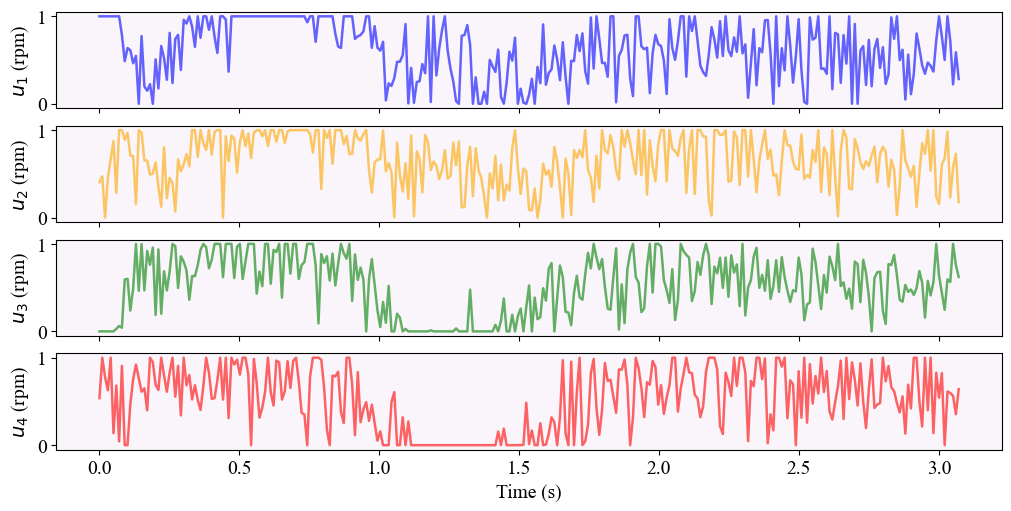

In [431]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

def plot_trajectories(logs1):
    fig, ax = plt.subplots(4, 1, sharex='col', figsize=(10, 5), constrained_layout=True)
    colors = ['blue', 'orange', 'green', 'red']
    styles = ['-', '--']
    lw = 1.8
    plt.rcParams["font.family"] = "Times New Roman"
    
    labels = ['h:5 m', 'h:7 m', 'h:10 m', 'h:15 m']
    
    k = 0
    handles = []
    for i, logs_0 in enumerate(logs1):
        for log in logs_0:
            if log is not None:
                if k == 0:
                    time = np.linspace(0, len(log['x']) / 100, len(log['x']))
                    color = colors[k % len(colors)]
                    linestyle = styles[k % len(styles)]
                    
                    p1, = ax[0].plot(time, log['u1'], linestyle=linestyle, linewidth=lw, alpha=0.6, color = colors[0])
                    p2, = ax[1].plot(time, log['u2'], linestyle=linestyle, linewidth=lw, alpha=0.6, color = colors[1])
                    p3, = ax[2].plot(time, log['u3'], linestyle=linestyle, linewidth=lw, alpha=0.6, color = colors[2])
                    p4, = ax[3].plot(time, log['u4'], linestyle=linestyle, linewidth=lw, alpha=0.6, color = colors[3])
                k +=1
                
               

    y_labels = ['$u_1$ (rpm)', '$u_2$ (rpm)', '$u_3$ (rpm)', '$u_4$ (rpm)']

    for i in range(4):
        ax[i].grid(False)
        # ax[i].set_facecolor('#f7f5fa')
        ax[i].set_facecolor('#f9f5fa')
        ax[i].tick_params(axis='both', which='major', labelsize=14)
        ax[i].set_ylabel(y_labels[i], fontsize=14)
    ax[3].set_xlabel('Time (s)', fontsize=14)
    fig.savefig("parrot_v16_d4e.pdf", bbox_inches='tight')
    # fig.suptitle('h:5 m')
    
    plt.show()


# log_b3_h0 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_0]
# log_b3_h1 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_1]

# log_b3_d7_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_0]
# log_b3_d7_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_1]

# log_b3_d10_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_0]
# log_b3_d10_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_1]
# Plotting

log_list = [log_b3_d10_1,log_b3_h1]



plot_trajectories(log_list) 

In [ ]:
def plot_trajectories(logs1):    
    fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)
    colors = ['salmon', 'turquoise', '#fdaa48']  # Define more colors as needed
    styles = ['-', '-','-','-']
    titles = ['f = 0Hz', 'f = 0.5Hz', 'f = 0.1Hz']
    labels = ['deviation [0m]', 'deviation [2m]', 'deviation [4m]']
    lw = 3
  
    for i, logs_0 in enumerate(logs1):
        k = 0
        i = 0
        for log in logs_0:  
            if i == 0:
                time = np.linspace(0, len(log['x'])/100, len(log['x']))
                ax[0, 0].plot(time, log['x'], linestyle=styles[k], linewidth = lw, color = colors[k])
                ax[0, 1].plot(time, -log['y'], linestyle=styles[k],  linewidth = lw, color = colors[k])
                ax[0, 2].plot(time, -log['z'], linestyle=styles[k],  linewidth = lw, color = colors[k])

                # Second row: vx, vy, vz
                ax[1, 0].plot(time, -log['vx'], linestyle=styles[k],  linewidth = lw, color = colors[k])
                ax[1, 1].plot(time, log['vy'], linestyle=styles[k],  linewidth = lw, color = colors[k])
                ax[1, 2].plot(time, log['vz'], linestyle=styles[k],  linewidth = lw, color = colors[k])

                # Third row: V, phi, theta, psi
                ax[2, 0].plot(time, log['phi'], linestyle=styles[k],  linewidth = lw, color = colors[k])
                ax[2, 1].plot(time, log['theta'], linestyle=styles[k],  linewidth = lw, color = colors[k])
                ax[2, 2].plot(time, log['psi'], linestyle=styles[k],  linewidth = lw, color = colors[k])
            i+=1
        k+=1
                
                
            
                    

    y_labels = ['$p_n$ (m)','$p_e$ (m)','$p_d$ (m)','$v_n$ (m/s)','$v_e$ (m/s)','$v_d$ (m/s)', '$\phi$ (rad)','$\Theta$ (rad)','$\psi$ (rad)']
 
    for i in range(3):
        for j in range(3):
            ax[i, j].grid(True, alpha=0.0)
            # ax[i, j].set_facecolor('#fdfdfe')
            #ax[i, j].set_facecolor('floralwhite')
            ax[i, j].set_facecolor('snow')
            # ax[i, j].set_alpha(0.1)
            ax[i, j].tick_params(axis='both', which='major', labelsize=16)
            ax[i, j].set_ylabel(y_labels[i*3+j], fontsize=16)
            ax[i, j].set_xlabel('Time (s)', fontsize=16)

    fig.legend(('h:5 m','h:10 m','h:15 m'), loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=5, fontsize = 16)
    #fig.suptitle('deviation = 4m', fontsize=18, fontweight = 'bold')
    # ax[0, 2].set_ylim(0,16)
         

    #fig.savefig("parrot_v16_d4.pdf", bbox_inches='tight')
    plt.show()


# log_b3_h0 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_0]
# log_b3_h1 = [load_log_data(base_path_3, file) for file in file_name_b3_heights_1]

# log_b3_d7_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_0]
# log_b3_d7_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev7_1]

# log_b3_d10_0 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_0]
# log_b3_d10_1 = [load_log_data(base_path_3, file) for file in file_name_b3_dev10_1]

##
# log_b1_h0 = [load_log_data(base_path_1, file) for file in file_name_b1_heights_0]
# log_b1_d7_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev7_0]
# log_b1_d10_0 = [load_log_data(base_path_1, file) for file in file_name_b1_dev10_0]

# Plotting
log_list = [log_b1_h0, log_b2_h0, log_b3_h0, log_b4_h0 ]


plot_trajectories(log_list) 

In [ ]:
def plot_trajectories(logs1):    
    fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)
    colors = ['salmon', 'turquoise', '#fdaa48']  # Define more colors as needed
    styles = ['-', '--']
    titles = ['f = 0Hz', 'f = 0.5Hz', 'f = 0.1Hz']
    labels = ['deviation [0m]', 'deviation [2m]', 'deviation [4m]']
    lw = 3

    for i, logs_0 in enumerate(logs1):
        for log in logs_0:
            if log is not None:
                time = np.linspace(0, len(log['x']) / 100, len(log['x']))
                if i == 0:
                    # First row: x, y, z
                    ax[0, 0].plot(time, log['x'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])
                    ax[0, 1].plot(time, -log['y'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])
                    ax[0, 2].plot(time, -log['z'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])

                    # Second row: vx, vy, vz
                    ax[1, 0].plot(time, log['vx'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])
                    ax[1, 1].plot(time, log['vy'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])
                    ax[1, 2].plot(time, log['vz'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])

                    # Third row: V, phi, theta, psi
                    ax[2, 0].plot(time, log['phi'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])
                    ax[2, 1].plot(time, log['theta'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])
                    ax[2, 2].plot(time, log['psi'], linestyle=styles[i % 2], linewidth=lw, color=colors[i])

                    # Add transparent red overlay for failed scenarios
                    if max(log['x']) < 2 or max(log['y']) < 2:  # Define your failure condition
                        ax[0, 0].plot(time, log['x'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[0, 1].plot(time, -log['y'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[0, 2].plot(time, -log['z'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[1, 0].plot(time, log['vx'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[1, 1].plot(time, log['vy'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[1, 2].plot(time, log['vz'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[2, 0].plot(time, log['phi'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[2, 1].plot(time, log['theta'], linewidth=lw * 1.5, color='red', alpha=0.3)
                        ax[2, 2].plot(time, log['psi'], linewidth=lw * 1.5, color='red', alpha=0.3)

    y_labels = ['$p_n$ (m)', '$p_e$ (m)', '$p_d$ (m)', '$v_n$ (m/s)', '$v_e$ (m/s)', '$v_d$ (m/s)', '$\\phi$ (rad)', '$\\Theta$ (rad)', '$\\psi$ (rad)']
 
    for i in range(3):
        for j in range(3):
            ax[i, j].grid(True, alpha=0.0)
            ax[i, j].set_facecolor('#fdfdfe')
            ax[i, j].tick_params(axis='both', which='major', labelsize=16)
            ax[i, j].set_ylabel(y_labels[i * 3 + j], fontsize=16)
            ax[i, j].set_xlabel('Time (s)', fontsize=16)

    fig.legend(('h:5 m', 'h:10 m', 'h:15 m'), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=16)
    fig.suptitle('deviation = 4m', fontsize=18, fontweight='bold')
    
    
    plt.show()

    # Plotting
log_list = [log_b3_d10_0,log_b3_d10_1]


plot_trajectories(log_list) 

In [10]:
test_env.reset()
action_list = []

def run():
    global action_list
    actions, _ = model.predict(test_env.states, deterministic=False)
    action_list.append(actions[0])
    states, rewards, dones, infos = test_env.step(actions)
    return test_env.render()


animation_cansu.view(run, gate_pos=test_env.start_platform_pos, gate_att=test_env.start_platform_att)
action_list = np.array(action_list)
print('action_list', action_list)

action_list [[ 1.         -1.         -1.          0.10396278]
 [ 1.         -1.         -1.          1.        ]
 [ 1.         -0.77611464 -1.          1.        ]
 ...
 [-0.11025861  1.          1.          1.        ]
 [-0.03596935 -0.6086484  -0.35820284  1.        ]
 [ 0.26245275 -0.6167911  -0.76386946  0.86431396]]


Generate C code

In [ ]:
import torch.nn as nn

# E2E_Net
path = 'models/E2E/test1/3000000.zip'

model = PPO.load(path)

# get network
network = list(model.policy.mlp_extractor.policy_net) + [model.policy.action_net]
network = nn.Sequential(*network)
print('NETWORK:')
print(network)

print(model.policy.action_dist)
print(model.policy.log_std)
print(model.policy.log_std.exp())
network_std = model.policy.log_std.exp().cpu().detach().numpy()
print(network_std)


In [ ]:
import torch
import torch.nn as nn
import os
import subprocess

# remove the c_code folder and all of its contents
subprocess.call('rm -rf c_code', shell=True)
# create a new c_code folder
subprocess.call('mkdir c_code', shell=True)

# Create the "c_code" folder if it doesn't exist
output_folder = "c_code"
os.makedirs(output_folder, exist_ok=True)

# Generate the C file and the header file inside the "c_code" folder
source_file_path = os.path.join(output_folder, "neural_network.c")
header_file_path = os.path.join(output_folder, "neural_network.h")

# np.float32 to str
float_to_str = lambda x: str(float(x))

# Generate the C file
with open(source_file_path, "w") as file:
    file.write('#include "neural_network.h"\n')
    file.write("#include <stdio.h>\n")
    file.write("#include <math.h>\n\n")

    # Define weights and biases as global constant float arrays
    i = 1
    for layer in network:
        if isinstance(layer, nn.Linear):
            weights_layer = layer.weight.data.cpu().numpy()
            biases_layer = layer.bias.data.cpu().numpy()

            file.write(f"const float weights_fc{i}[] = {{\n")
            file.write(",\n".join([", ".join(map(float_to_str, row)) for row in weights_layer]))
            file.write("\n};\n\n")

            file.write(f"const float biases_fc{i}[] = {{\n")
            file.write(", ".join(map(float_to_str, biases_layer)))
            file.write("\n};\n\n")

            i+=1

    # LINEAR LAYER
    file.write("void nn_linear(const float* weights, const float* biases, const float* input, int in_features, int out_features, float* output) {\n")
    file.write("    for (int i = 0; i < out_features; ++i) {\n")
    file.write("        float neuron = biases[i];\n")
    file.write("        for (int j = 0; j < in_features; ++j) {\n")
    file.write("            neuron += input[j] * weights[i * in_features + j];\n")
    file.write("        }\n")
    file.write("        output[i] = neuron;\n")
    file.write("    }\n")
    file.write("}\n\n")

    # RELU LAYER
    file.write("void nn_relu(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = fmaxf(0, input[i]);\n")
    file.write("    }\n")
    file.write("}\n\n")

    # TANH LAYER
    file.write("void nn_tanh(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = tanh(input[i]);\n")
    file.write("    }\n")
    file.write("}\n\n")

    # FORWARD FUNCTION
    file.write("void nn_forward(const float* input, float* output) {\n")
    layer_size = network[0].out_features
    num_layers = sum(isinstance(layer, nn.Linear) for layer in network)
    i=0
    input_array = "input"
    for layer in network:
        if isinstance(layer, nn.Linear):
            i+=1
            if i<num_layers:
                file.write(f"    float fc{i}_output[{layer.out_features}];\n")
                file.write(f"    nn_linear(weights_fc{i}, biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, fc{i}_output);\n")
                input_array = f"fc{i}_output"
            else:
                file.write(f"    nn_linear(weights_fc{i}, biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, output);\n")
                input_array = "output"
            layer_size = layer.out_features
        elif isinstance(layer, nn.ReLU):
            file.write(f"    nn_relu({input_array}, {layer_size});\n")
        elif isinstance(layer, nn.Tanh):
            file.write(f"    nn_tanh({input_array}, {layer_size});\n")
        else:
            raise Exception(f"Unsupported layer: {layer}")
    file.write("}\n")

# Generate the header file
with open(header_file_path, "w") as header_file:
    header_file.write("#ifndef NEURAL_NETWORK_H\n")
    header_file.write("#define NEURAL_NETWORK_H\n\n")
    # Declare the forward function in the header file
    header_file.write("void nn_forward(const float* input, float* output);\n")
    header_file.write("\n#endif // NEURAL_NETWORK_H\n")


# Print the generated files
# Print the generated files
print(f"Generated {source_file_path}")
print(f"Generated {header_file_path}")

In [ ]:
name = 'nn_controller'
# Create the "c_code" folder if it doesn't exist
output_folder = "c_code"
os.makedirs(output_folder, exist_ok=True)

# Generate the C file and the header file inside the "c_code" folder
source_file_path = os.path.join(output_folder, f"{name}.c")
header_file_path = os.path.join(output_folder, f"{name}.h")

num_gates = test_env.num_gates
gates_ahead = test_env.gates_ahead
disturbance_input = True
ranges = test_env.disturbance_ranges

# Generate the header file
with open(header_file_path, "w") as file:
    file.write(f"#ifndef {name.upper()}_H\n")
    file.write(f"#define {name.upper()}_H\n")
    file.write("\n")
    file.write("#include <stdint.h>\n")
    file.write("#include <stdbool.h>\n")
    file.write("\n")
    file.write(f'#define GATES_AHEAD {gates_ahead}\n')
    file.write(f'#define NUM_GATES {num_gates}\n')
    file.write("\n")
    # include neural network code
    file.write("// Include the neural network code\n")
    file.write("#include \"neural_network.h\"\n")
    file.write("\n")
    file.write("const float gate_pos[NUM_GATES][3];\n")
    file.write("const float gate_yaw[NUM_GATES];\n")
    file.write("const float start_pos[3];\n")
    # file.write("const float gate_pos_rel[NUM_GATES][3];\n")
    # file.write("const float gate_yaw_rel[NUM_GATES];\n")
    file.write("uint8_t target_gate_index;\n")
    file.write("\n")
    # nn_reset function that resets the target gate index
    file.write("void nn_reset(void);\n")
    # nn_control function that that takes as input a float array of size 16 (world_state) and outputs an array of size 4 (rpms)
    
    #DISTURBANCE INPUT
    if disturbance_input:
        file.write("void nn_control(const float world_state[16], const float disturbances[4], float rpms[4]);\n")
    else:
        file.write("void nn_control(const float world_state[16], float rpms[4]);\n")
    
    file.write("\n")
    file.write("#endif\n")

# Generate the C file
with open(source_file_path, "w") as file:
    file.write(f"#include \"{name}.h\"\n")
    file.write("#include <math.h>\n")
    file.write("#include <stdlib.h>\n")
    file.write("\n")
    # define boolean to set controller to determistic
    file.write("bool deterministic = false;\n")
    file.write("\n")
    file.write("const float output_std[4] = {\n")
    for i in range(4):
        file.write(f"    {network_std[i]},\n")
    file.write("};\n")
    file.write("\n")
    # define the gate positions and headings as const float arrays
    file.write("const float gate_pos[NUM_GATES][3] = {\n")
    for i in range(num_gates):
        file.write(f"    {{{test_env.gate_pos[i][0]}, {test_env.gate_pos[i][1]}, {test_env.gate_pos[i][2]}}},\n")
    file.write("};\n")
    file.write("\n")
    file.write("const float gate_yaw[NUM_GATES] = {\n")
    for i in range(num_gates):
        file.write(f"    {test_env.gate_yaw[i]},\n")
    file.write("};\n")
    file.write("\n")
    # define the start pos as a const float array
    file.write("const float start_pos[3] = {\n")
    file.write(f"    {test_env.start_pos[0]}, {test_env.start_pos[1]}, {test_env.start_pos[2]}\n")
    file.write("};\n")
    file.write("\n")
    # define the relative gate positions and headings as const float arrays
    file.write("const float gate_pos_rel[NUM_GATES][3] = {\n")
    for i in range(num_gates):
        file.write(f"    {{{test_env.gate_pos_rel[i][0]}, {test_env.gate_pos_rel[i][1]}, {test_env.gate_pos_rel[i][2]}}},\n")
    file.write("};\n")
    file.write("\n")
    file.write("const float gate_yaw_rel[NUM_GATES] = {\n")
    for i in range(num_gates):
        file.write(f"    {test_env.gate_yaw_rel[i]},\n")
    file.write("};\n")
    file.write("\n")
    # define the target gate index and set it to 0
    file.write("uint8_t target_gate_index = 0;\n")
    file.write("\n")
    file.write("void nn_reset() {\n")
    file.write("    target_gate_index = 0;\n")
    file.write("}\n")
    file.write("\n")
    if disturbance_input:
        file.write("void nn_control(const float world_state[16], const float disturbances[4], float rpms[4]) {\n")
    else:
        file.write("void nn_control(const float world_state[16], float rpms[4]) {\n")
    file.write("    // Get the current position, velocity and heading\n")
    file.write("    float pos[3] = {world_state[0], world_state[1], world_state[2]};\n")
    file.write("    float vel[3] = {world_state[3], world_state[4], world_state[5]};\n")
    file.write("    float yaw = world_state[8];\n")
    file.write("\n")
    file.write("    // Get the position and heading of the target gate\n")
    file.write("    float target_pos[3] = {gate_pos[target_gate_index][0], gate_pos[target_gate_index][1], gate_pos[target_gate_index][2]};\n")
    file.write("    float target_yaw = gate_yaw[target_gate_index];\n")
    file.write("\n")
    file.write("    // Set the target gate index to the next gate if we passed through the current one\n")
    file.write("    if (cosf(target_yaw) * (pos[0] - target_pos[0]) + sinf(target_yaw) * (pos[1] - target_pos[1]) > 0) {\n")
    file.write("        target_gate_index++;\n")
    file.write("        // loop back to the first gate if we reach the end\n")
    file.write("        target_gate_index = target_gate_index % NUM_GATES;\n")
    file.write("        // reset the target position and heading\n")
    file.write("        target_pos[0] = gate_pos[target_gate_index][0];\n")
    file.write("        target_pos[1] = gate_pos[target_gate_index][1];\n")
    file.write("        target_pos[2] = gate_pos[target_gate_index][2];\n")
    file.write("        target_yaw = gate_yaw[target_gate_index];\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    // Get the position of the drone in gate frame\n")
    file.write("    float pos_rel[3] = {\n")
    file.write("        cosf(target_yaw) * (pos[0] - target_pos[0]) + sinf(target_yaw) * (pos[1] - target_pos[1]),\n")
    file.write("        -sinf(target_yaw) * (pos[0] - target_pos[0]) + cosf(target_yaw) * (pos[1] - target_pos[1]),\n")
    file.write("        pos[2] - target_pos[2]\n")
    file.write("    };\n")
    file.write("\n")
    file.write("    // Get the velocity of the drone in gate frame\n")
    file.write("    float vel_rel[3] = {\n")
    file.write("        cosf(target_yaw) * vel[0] + sinf(target_yaw) * vel[1],\n")
    file.write("        -sinf(target_yaw) * vel[0] + cosf(target_yaw) * vel[1],\n")
    file.write("        vel[2]\n")
    file.write("    };\n")
    file.write("\n")
    file.write("    // Get the heading of the drone in gate frame\n")
    file.write("    float yaw_rel = yaw - target_yaw;\n")
    file.write("    while (yaw_rel > M_PI) {yaw_rel -= 2*M_PI;}\n")
    file.write("    while (yaw_rel < -M_PI) {yaw_rel += 2*M_PI;}\n")
    file.write("\n")
    file.write("    // Get the neural network input\n")
    if disturbance_input:
        file.write("    float nn_input[16+4*GATES_AHEAD+4];\n")
    else:
        file.write("    float nn_input[16+4*GATES_AHEAD];\n")
    file.write("    // position and velocity\n")
    file.write("    for (int i = 0; i < 3; i++) {\n")
    file.write("        nn_input[i] = pos_rel[i];\n")
    file.write("        nn_input[i+3] = vel_rel[i];\n")
    file.write("    }\n")
    file.write("    // attitude\n")
    file.write("    nn_input[6] = world_state[6];\n")
    file.write("    nn_input[7] = world_state[7];\n")
    file.write("    nn_input[8] = yaw_rel;\n")
    file.write("    // body rates\n")
    file.write("    nn_input[9] = world_state[9];\n")
    file.write("    nn_input[10] = world_state[10];\n")
    file.write("    nn_input[11] = world_state[11];\n")
    file.write("    // motor rpms scaled to [-1,1]\n")
    file.write(f"    float w_min = {w_min};\n")
    file.write(f"    float w_max = {w_max};\n")
    file.write("    nn_input[12] = (world_state[12] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("    nn_input[13] = (world_state[13] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("    nn_input[14] = (world_state[14] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("    nn_input[15] = (world_state[15] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("\n")
    file.write("    // relative gate positions and headings\n")
    file.write("    for (int i = 0; i < GATES_AHEAD; i++) {\n")
    file.write("        uint8_t index = target_gate_index + i + 1;\n")
    file.write("        // loop back to the first gate if we reach the end\n")
    file.write("        index = index % NUM_GATES;\n")
    file.write("        nn_input[16+4*i]   = gate_pos_rel[index][0];\n")
    file.write("        nn_input[16+4*i+1] = gate_pos_rel[index][1];\n")
    file.write("        nn_input[16+4*i+2] = gate_pos_rel[index][2];\n")
    file.write("        nn_input[16+4*i+3] = gate_yaw_rel[index];\n")
    file.write("    }\n")
    # DISTURBANCES
    if disturbance_input:
        # file.write("    // disturbance input\n")
        # file.write(f"    float Mx_mean = {test_env.Mx_mean};\n")
        # file.write(f"    float Mx_std = {test_env.Mx_std};\n")
        # file.write(f"    float My_mean = {test_env.My_mean};\n")
        # file.write(f"    float My_std = {test_env.My_std};\n")
        # file.write(f"    float Mz_mean = {test_env.Mz_mean};\n")
        # file.write(f"    float Mz_std = {test_env.Mz_std};\n")
        # file.write(f"    float Fz_mean = {test_env.Fz_mean};\n")
        # file.write(f"    float Fz_std = {test_env.Fz_std};\n")
        # file.write("\n")
        # file.write("    nn_input[16+4*GATES_AHEAD]   = (disturbances[0] - Mx_mean) / Mx_std;\n")
        # file.write("    nn_input[16+4*GATES_AHEAD+1] = (disturbances[1] - My_mean) / My_std;\n")
        # file.write("    nn_input[16+4*GATES_AHEAD+2] = (disturbances[2] - Mz_mean) / Mz_std;\n")
        # file.write("    nn_input[16+4*GATES_AHEAD+3] = (disturbances[3] - Fz_mean) / Fz_std;\n")
        file.write("    // disturbance input\n")
        file.write(f"    float Mx_min = {ranges[0][0]};\n")
        file.write(f"    float Mx_max = {ranges[0][1]};\n")
        file.write(f"    float My_min = {ranges[1][0]};\n")
        file.write(f"    float My_max = {ranges[1][1]};\n")
        file.write(f"    float Mz_min = {ranges[2][0]};\n")
        file.write(f"    float Mz_max = {ranges[2][1]};\n")
        file.write(f"    float Fz_min = {ranges[5][0]};\n")
        file.write(f"    float Fz_max = {ranges[5][1]};\n")
        file.write("    nn_input[16+4*GATES_AHEAD]   = (disturbances[0] - Mx_min) * 2 / (Mx_max - Mx_min) - 1;\n")
        file.write("    nn_input[16+4*GATES_AHEAD+1] = (disturbances[1] - My_min) * 2 / (My_max - My_min) - 1;\n")
        file.write("    nn_input[16+4*GATES_AHEAD+2] = (disturbances[2] - Mz_min) * 2 / (Mz_max - Mz_min) - 1;\n")
        file.write("    nn_input[16+4*GATES_AHEAD+3] = (disturbances[3] - Fz_min) * 2 / (Fz_max - Fz_min) - 1;\n")
        file.write("\n")
    file.write("    // Get the neural network output and write to the action array\n")
    file.write("    float nn_output[4];\n")
    file.write("    nn_forward(nn_input, nn_output);\n")
    file.write("\n")
    # if determinstic is false, add gaussian noise to the output
    file.write("    // add gaussian noise to the output\n")
    file.write("    if (!deterministic) {\n")
    file.write("        for (int i = 0; i < 4; i++) {\n")
    # generate random gaussian variables using the Box–Muller transform
    file.write("            // generate random gaussian variables using the Box–Muller transform\n")
    file.write("            float u1 = (float)rand() / RAND_MAX;\n")
    file.write("            float u2 = (float)rand() / RAND_MAX;\n")
    file.write("            float rand_std = sqrtf(-2 * logf(u1)) * cosf(2 * M_PI * u2);\n")
    file.write("            // add the noise to the output\n")
    file.write("            nn_output[i] += output_std[i] * rand_std;\n")
    file.write("        }\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    for (int i = 0; i < 4; i++) {\n")
    file.write("        // clip the output to the range [-1, 1]\n")
    file.write("        if (nn_output[i] > 1) {nn_output[i] = 1;}\n")
    file.write("        if (nn_output[i] < -1) {nn_output[i] = -1;}\n")
    file.write("         // map the output to the range [w_min, w_max]\n")
    file.write(f"        rpms[i] = (w_max - w_min) * (nn_output[i] + 1) / 2 + w_min;\n")
    file.write("    }\n")
    file.write("}\n")

# Print the generated files
print(f"Generated {source_file_path}")
print(f"Generated {header_file_path}")

Test C code

In [ ]:
import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Create object files
subprocess.call('gcc -fPIC -c *.c', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
fun = ctypes.CDLL(lib_path)

# define argument types 
fun.nn_forward.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float)]
if disturbance_input:
    fun.nn_control.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float)]
else:
    fun.nn_control.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float)]

In [ ]:
def c_network(x):
    x = np.array(x, dtype=np.float32)
    c_net_input = (ctypes.c_float*len(x))(*x)
    c_net_output = (ctypes.c_float*4)()
    fun.nn_forward(c_net_input, c_net_output)
    out = np.array(c_net_output[:])
    return np.clip(out, -1,1)

def torch_network(x):
    x = torch.tensor(x, dtype=torch.float32)
    out = network(x).cpu().detach().numpy()
    return np.clip(out, -1,1)

def nn_control_d_input(x, d):
    x = np.array(x, dtype=np.float32)
    d = np.array(d, dtype=np.float32)

    # scale to [w_min, w_max]
    x[12:16] = (x[12:16] + 1)/2*(w_max - w_min) + w_min

    c_net_input_1 = (ctypes.c_float*len(x))(*x)
    c_net_input_2 = (ctypes.c_float*len(d))(*d)
    c_net_output = (ctypes.c_float*4)()
    
    fun.nn_control(c_net_input_1, c_net_input_2, c_net_output)
    out = np.array(c_net_output[:])

    # map back to [-1,1]
    out = (out - w_min)/(w_max - w_min)*2 - 1
    return out

def nn_control(x):
    x = np.array(x, dtype=np.float32)

    # scale to [w_min, w_max]
    x[12:16] = (x[12:16] + 1)/2*(w_max - w_min) + w_min

    c_net_input = (ctypes.c_float*len(x))(*x)
    c_net_output = (ctypes.c_float*4)()
    
    
    fun.nn_control(c_net_input, c_net_output)
    out = np.array(c_net_output[:])
    # map back to [-1,1]
    out = (out - w_min)/(w_max - w_min)*2 - 1
    return out


# test
x = np.random.rand(24)
full = lambda x: [float(xi) for xi in x]
print(full(c_network(x)))
print(full(torch_network(x)))

In [ ]:
# Simulate C Network
test_env.reset()
fun.nn_reset()

crashes = []
steps = 0

def run():
    # state = test_env.states[0]
    # action1 = c_network(state.copy())
    # print(state)

    world_state = test_env.world_states[0]
    d_input = test_env.disturbances[0, [0,1,2,5]]
    action = nn_control_d_input(world_state.copy(), d_input.copy())
    
    actions = np.array([action])

    steps = test_env.step_counts[0]+1
    states, rewards, dones, infos = test_env.step(actions)

    if dones[0]:
        crash = steps != test_env.max_steps
        crashes.append(crash)
        if crash:
            print('crash')
        else:
            print('success')
        fun.nn_reset()
    if len(crashes) == 100:
        print(f"Crash rate: {np.mean(crashes)}")
        # raise KeyboardInterrupt
    return test_env.render()

animation.view(run, gate_pos=test_env.gate_pos, gate_yaw=test_env.gate_yaw)

In [ ]:
import torch
import torch.nn as nn
import os

# Create the "c_code" folder if it doesn't exist
output_folder = "c_code"
os.makedirs(output_folder, exist_ok=True)

name = 'nn_moment'

network = moment_model

# Generate the C file and the header file inside the "c_code" folder
source_file_path = os.path.join(output_folder, f'{name}.c')
header_file_path = os.path.join(output_folder, f'{name}.h')

# np.float32 to str
float_to_str = lambda x: str(float(x))

# Generate the C file
with open(source_file_path, "w") as file:
    file.write('#include "nn_thrust.h"\n')
    file.write("#include <stdio.h>\n")
    file.write("#include <math.h>\n\n")

    # Define weights and biases as global constant float arrays
    i = 1
    for layer in network:
        if isinstance(layer, nn.Linear):
            weights_layer = layer.weight.data.cpu().numpy()
            biases_layer = layer.bias.data.cpu().numpy()

            file.write(f"const float {name}_weights_fc{i}[] = {{\n")
            file.write(",\n".join([", ".join(map(float_to_str, row)) for row in weights_layer]))
            file.write("\n};\n\n")

            file.write(f"const float {name}_biases_fc{i}[] = {{\n")
            file.write(", ".join(map(float_to_str, biases_layer)))
            file.write("\n};\n\n")

            i+=1

    # LINEAR LAYER
    file.write("void "+name+"_linear(const float* weights, const float* biases, const float* input, int in_features, int out_features, float* output) {\n")
    file.write("    for (int i = 0; i < out_features; ++i) {\n")
    file.write("        float neuron = biases[i];\n")
    file.write("        for (int j = 0; j < in_features; ++j) {\n")
    file.write("            neuron += input[j] * weights[i * in_features + j];\n")
    file.write("        }\n")
    file.write("        output[i] = neuron;\n")
    file.write("    }\n")
    file.write("}\n\n")

    # RELU LAYER
    file.write("void "+name+"_relu(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = fmaxf(0, input[i]);\n")
    file.write("    }\n")
    file.write("}\n\n")

    # TANH LAYER
    file.write("void "+name+"_tanh(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = tanh(input[i]);\n")
    file.write("    }\n")
    file.write("}\n\n")

    # FORWARD FUNCTION
    file.write("void "+name+"_forward(const float* input, float* output) {\n")
    layer_size = network[0].out_features
    num_layers = sum(isinstance(layer, nn.Linear) for layer in network)
    i=0
    input_array = "input"
    for layer in network:
        if isinstance(layer, nn.Linear):
            i+=1
            if i<num_layers:
                file.write(f"    float fc{i}_output[{layer.out_features}];\n")
                file.write(f"    {name}_linear({name}_weights_fc{i}, {name}_biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, fc{i}_output);\n")
                input_array = f"fc{i}_output"
            else:
                file.write(f"    {name}_linear({name}_weights_fc{i}, {name}_biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, output);\n")
                input_array = "output"
            layer_size = layer.out_features
        elif isinstance(layer, nn.ReLU):
            file.write(f"    {name}_relu({input_array}, {layer_size});\n")
        elif isinstance(layer, nn.Tanh):
            file.write(f"    {name}_tanh({input_array}, {layer_size});\n")
        else:
            raise Exception(f"Unsupported layer: {layer}")
    file.write("}\n")

# Generate the header file
with open(header_file_path, "w") as header_file:
    header_file.write(f'#ifndef {name.upper()}_H\n')
    header_file.write(f'#define {name.upper()}_H\n\n')
    # Declare the forward function in the header file
    header_file.write("void "+name+"_forward(const float* input, float* output);\n")
    header_file.write(f'\n#endif // {name.upper()}_H\n')


# Print the generated files
print(f"Generated {source_file_path}")
print(f"Generated {header_file_path}")